# Load librairies

In [ ]:
!pip3 install statsmodels

In [ ]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import statsmodels.api as sm

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [ ]:
path = '/content/drive/MyDrive/data consumer insights'

In [ ]:
stores = pd.read_csv(path+'/stores.csv')
train_df = pd.read_csv(path+'/train_consumer_insights.csv')
test_df = pd.read_csv(path+'/test_consumer_insights.csv')



/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Preprocessing

In [ ]:
promos_variables = {"Promo2SinceWeek": 100,"Promo2SinceYear":2000 ,"PromoInterval": "No promo"}
def preprocess_f(x):
  if x.name in list(promos_variables.keys()):
    return x.fillna(promos_variables[x.name])
  elif is_numeric_dtype(x) and x.name!= "Store":
    x = pd.to_numeric(x)
    x = x.fillna(x.mean())
    return (x-x.mean())/x.std()
  
  else:
    return x.fillna(x.mode)

stores = stores.apply(preprocess_f)
stores.reset_index(inplace=True, drop=True)
cols = ["PromoInterval","StoreType","Assortment"]
for col in cols:
  l = pd.get_dummies(stores[col], prefix=col)
  stores.drop(columns = [col],inplace=True)
  stores = pd.concat([stores,l],axis=1)

In [ ]:
train_df["Year"],train_df["Month"], train_df["Day"] = train_df["Date"].apply(lambda x: x.split("-")[0])\
,train_df["Date"].apply(lambda x: x.split("-")[1]),train_df["Date"].apply(lambda x: x.split("-")[2])

In [ ]:
from datetime import datetime
m = datetime.strptime(train_df["Date"].min(),'%Y-%m-%d')
train_df["time_diff"] = train_df["Date"].apply(lambda x: abs((datetime.strptime(x,'%Y-%m-%d') - m).days))

In [ ]:
train_df = train_df.drop(columns=["Date"])

In [ ]:
dummy_var_train_df = ["Year","Month","Day","StateHoliday","SchoolHoliday"]
for col in dummy_var_train_df:
  l = pd.get_dummies(train_df[col], prefix=col)
  train_df.drop(columns = [col],inplace=True)
  train_df = pd.concat([train_df,l],axis=1)

In [ ]:
df = pd.merge(train_df, stores, how='inner', on="Store")


In [ ]:
## To run only for time series forecasting
store_id = 190
store_time_series = df[df["Store"]==store_id]

In [ ]:
#df = df.sample(100000)
df.reset_index(inplace=True, drop=True)
df.drop(columns="Store",inplace=True)
# l = pd.get_dummies(df["Store"], prefix="Store")
# df.drop(columns = ["Store"],inplace=True)
# df = pd.concat([df,l], axis=1)

In [ ]:
X=df.drop(columns=["Sales","time_diff"])
y=df["Sales"]
exog = sm.add_constant(X)
mod = sm.OLS(y,exog)
sales_regression = mod.fit()
#sales_regression = sm.OLS(y,X).fit()

sales_regression.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                 1.486e+05
Date:                Tue, 03 May 2022   Prob (F-statistic):               0.00
Time:                        16:40:58   Log-Likelihood:            -8.6456e+06
No. Observations:             1017209   AIC:                         1.729e+07
Df Residuals:                 1017143   BIC:                         1.729e+07
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           2.705e+04    694.016     38.978      0.000    2.57e+04    2.84e+04
DayOfWeek                        -50.9310      0.781    -65.206      0.000     -52.462     -49.400
Customers                          7.1755      0.004   1845.569      0.000       7.168       7.183
Open                             921.5402      4.936    186.687      0.000     911.865     931.215
Promo                           1087.2511      2.861    379.990      0.000    1081.643    1092.859
Year_2013                       8890.7279    231.361     38.428      0.000    8437.268    9344.188
Year_2014                       8990.4573    231.328     38.865      0.000    8537.062    9443.852
Year_2015                       9169.9996    231.351     39.637      0.000    8716.559    9623.441
Month_01                        2129.7663     57.964     36.743      0.000    2016.159    2243.374
Month_02                        2149.5380     57.986     37.070      0.000    2035.887    2263.189
Month_03                        2206.2872     57.966     38.062      0.000    2092.676    2319.899
Month_04                        2203.3117     57.974     38.005      0.000    2089.685    2316.938
Month_05                        2233.5306     57.969     38.530      0.000    2119.914    2347.147
Month_06                        2280.3559     57.970     39.337      0.000    2166.737    2393.975
Month_07                        2221.7485     57.954     38.337      0.000    2108.161    2335.336
Month_08                        2126.2295     58.029     36.641      0.000    2012.494    2239.965
Month_09                        2091.6400     58.010     36.057      0.000    1977.943    2205.337
Month_10                        2082.4368     57.999     35.905      0.000    1968.760    2196.113
Month_11                        2364.7228     58.006     40.767      0.000    2251.034    2478.412
Month_12                        2961.6173     58.007     51.056      0.000    2847.926    3075.309
Day_01                          1107.1067     23.362     47.390      0.000    1061.319    1152.895
Day_02                          1118.5722     23.290     48.029      0.000    1072.926    1164.219
Day_03                           964.7889     23.295     41.416      0.000     919.131    1010.447
Day_04                           975.5051     23.291     41.884      0.000     929.856    1021.154
Day_05                           870.4324     23.295     37.365      0.000     824.775     916.090
Day_06                           768.3188     23.291     32.987      0.000     722.668     813.969
Day_07                           790.0864     23.287     33.929      0.000     744.445     835.728
Day_08                           731.7255     23.285     31.425      0.000     686.089     777.362
Day_09        

# Forecast

In [ ]:
import tensorflow as tf

In [ ]:
store_time_series = store_time_series[['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'time_diff','StateHoliday_0', 'StateHoliday_0',
       'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'SchoolHoliday_0',
       'SchoolHoliday_1', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval_Feb,May,Aug,Nov',
       'PromoInterval_Jan,Apr,Jul,Oct', 'PromoInterval_Mar,Jun,Sept,Dec',
       'PromoInterval_No promo', 'StoreType_a', 'StoreType_b', 'StoreType_c',
       'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c']]

In [ ]:
# store_time_series = store_time_series[store_time_series["time_diff"]>=740]

In [ ]:
store_time_series["Sales"].value_counts()

0       136
5791      2
8490      2
5494      2
5854      2
       ... 
6013      1
7298      1
9373      1
6457      1
6927      1
Name: Sales, Length: 591, dtype: int64

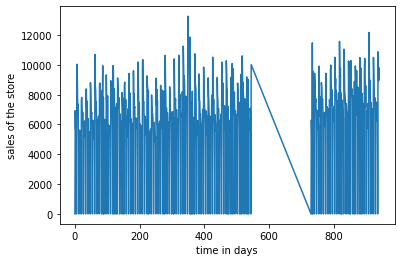

In [ ]:
import matplotlib.pyplot as plt
t = store_time_series['time_diff']
Y = store_time_series['Sales']
plt.plot(t,Y)
plt.xlabel ("time in days")
plt.ylabel ("sales of the store")
plt.show()
plt.show()

In [ ]:
vars = np.array(t)

vars = np.vstack((vars,np.array([x**2 for x in t])))
vars = np.vstack((vars,np.array([x**3 for x in t])))
# vars.append(t)
# vars.append([x**2 for x in t]) 
# vars.append([x**3 for x in t])

In [ ]:
from scipy.fft import fft, fftfreq, ifft

N = len(Y)
T = 1
fft_y = fft(Y)

xf = fftfreq(N, T)[:N//2]

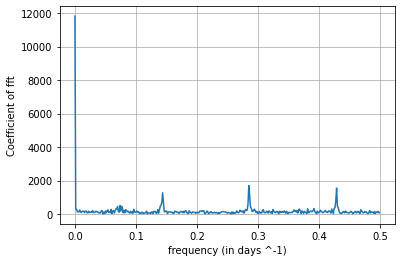

In [ ]:
plt.plot(xf, 2.0/N * np.abs(fft_y[0:N//2]))
plt.grid()
plt.xlabel ("frequency (in days ^-1)")
plt.ylabel ("Coefficient of fft")
plt.show()
plt.show()

In [ ]:
freqs = [x for _, x in sorted(zip(fft_y, xf),reverse=True)][0:30]

In [ ]:
from math import pi, cos, sin
for freq in freqs:
  vars = np.vstack((vars,np.array([cos(2*pi*freq*x) for x in t])))
  vars = np.vstack((vars,np.array([sin(2*pi*freq*x) for x in t])))

In [ ]:
test_df = pd.DataFrame(vars.T)

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(vars.T,Y)

LinearRegression()

In [ ]:
exog = sm.add_constant(vars.T)
mod = sm.OLS(Y,exog)
lr = mod.fit()
#lr = sm.OLS(Y,vars.T).fit()

lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     7.676
Date:                Tue, 03 May 2022   Prob (F-statistic):           2.96e-46
Time:                        16:44:21   Log-Likelihood:                -6970.5
No. Observations:                 758   AIC:                         1.406e+04
Df Residuals:                     696   BIC:                         1.435e+04
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.7583      3.241      0.851      0.395      -3.606       9.122
x2            -0.0063      0.009     -0.734      0.463      -0.023       0.011
x3          5.347e-06   6.24e-06      0.858      0.391   -6.89e-06    1.76e-05
const       5374.5544    330.561     16.259      0.000    4725.538    6023.571
x4          2.944e-12   1.44e-12      2.043      0.041    1.14e-13    5.77e-12
x5          -622.4828    135.156     -4.606      0.000    -887.845    -357.121
x6          -831.0203    135.251     -6.144      0.000   -1096.570    -565.471
x7          -629.3321    136.276     -4.618      0.000    -896.894    -361.770
x8         -1702.0280    136.933    -12.430      0.000   -1970.880   -1433.176
x9          -155.8347    171.554     -0.908      0.364    -492.660     180.990
x10           11.9150    171.414      0.070      0.945    -324.635     348.465
x11         1428.7345    156.093      9.153      0.000    1122.265    1735.204
x12           82.1190    156.051      0.526      0.599    -224.268     388.506
x13         -184.4002    169.754     -1.086      0.278    -517.691     148.891
x14          -12.1409    171.107     -0.071      0.943    -348.088     323.806
x15         -276.8043    127.941     -2.164      0.031    -528.001     -25.608
x16         -164.4270    128.032     -1.284      0.199    -415.801      86.947
x17         -688.9648    135.829     -5.072      0.000    -955.648    -422.281
x18          270.8083    135.733      1.995      0.046       4.313     537.303
x19          108.2186    127.905      0.846      0.398    -142.907     359.344
x20         -128.0443    128.162     -0.999      0.318    -379.676     123.587
x21          -41.4525    127.819     -0.324      0.746    -292.409     209.504
x22          -65.5082    127.997     -0.512      0.609    -316.814     185.797
x23         -216.8613    129.207     -1.678      0.094    -470.543      36.820
x24          -87.2997    129.464     -0.674      0.500    -341.487     166.887
x25         -214.8727    128.342     -1.674      0.095    -466.857      37.112
x26         -160.7062    127.634     -1.259      0.208    -411.300      89.887
x27          181.4451    128.524      1.412      0.158     -70.896     433.786
x28         -199.4811    128.327     -1.554      0.121    -451.436      52.474
x29           43.4299    139.003      0.312      0.755    -229.485     316.345
x30         -145.7701    138.816     -1.050      0.294    -418.318     126.777
x31          238.5828    134.956      1.768      0.078     -26.387     503.552
x32          121.6376    134.587      0.904      0.366    -142.607     385.882
x33         -193.5060    127.969     -1.512      0.131    -444.757      57.745
x34           76.7156    127.892      0.600      0.549    -174.384     327.815
x35            4.7061    128.573      0.037      0.971    -247.730     257.143
x3

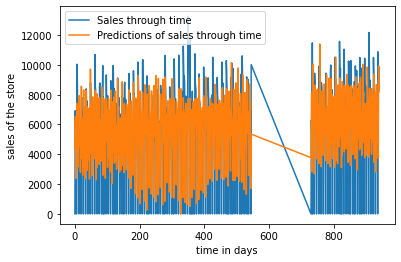

In [ ]:
plt.plot(t,Y,label="Sales through time")
plt.plot(t,lr.predict(vars.T),label="Predictions of sales through time")
plt.xlabel ("time in days")
plt.ylabel ("sales of the store")
plt.legend()
plt.show()

In [ ]:
t_prediction = np.arange(t.max(),t.max()+42,1)
vars_predict = np.array(t_prediction)

vars_predict = np.vstack((vars_predict,np.array([x**2 for x in t_prediction])))
vars_predict = np.vstack((vars_predict,np.array([x**3 for x in t_prediction])))
for freq in freqs:
  vars_predict = np.vstack((vars_predict,np.array([cos(2*pi*freq*x) for x in t_prediction])))
  vars_predict = np.vstack((vars_predict,np.array([sin(2*pi*freq*x) for x in t_prediction])))

In [ ]:
predictions = lr.predict(vars_predict.T)

Text(0, 0.5, 'predictions of sales of the store')

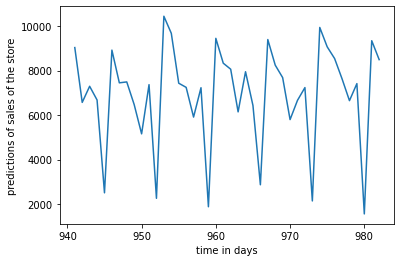

In [ ]:
plt.plot(t_prediction,predictions)
plt.xlabel ("time in days")
plt.ylabel ("predictions of sales of the store")

# Forecast with only opened days

In [ ]:
import tensorflow as tf

In [ ]:
store_time_series = store_time_series[['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'time_diff','StateHoliday_0', 'StateHoliday_0',
       'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'SchoolHoliday_0',
       'SchoolHoliday_1', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval_Feb,May,Aug,Nov',
       'PromoInterval_Jan,Apr,Jul,Oct', 'PromoInterval_Mar,Jun,Sept,Dec',
       'PromoInterval_No promo', 'StoreType_a', 'StoreType_b', 'StoreType_c',
       'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c']]

In [ ]:
store_time_series = store_time_series[store_time_series["time_diff"]>=740]

In [ ]:
store_time_series = store_time_series[store_time_series["Open"]==1]

In [ ]:
def transf(x):
  x["time_diff"] = len(store_time_series)-x.name
  return x
store_time_series.reset_index(inplace=True,drop=True)
store_time_series = store_time_series.apply(transf, axis=1)

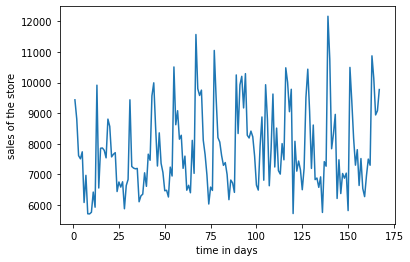

In [ ]:
import matplotlib.pyplot as plt
t = store_time_series['time_diff']
Y = store_time_series['Sales']
plt.plot(t,Y)
plt.xlabel ("time in days")
plt.ylabel ("sales of the store")
plt.show()

In [ ]:
vars = np.array(t)

vars = np.vstack((vars,np.array([x**2 for x in t])))

# vars.append(t)
# vars.append([x**2 for x in t]) 
# vars.append([x**3 for x in t])

In [ ]:
vars.shape

(2, 167)

In [ ]:
from scipy.fft import fft, fftfreq, ifft

N = len(Y)
T = 1
fft_y = fft(Y.to_numpy())

xf = fftfreq(N, T)[:N//2]

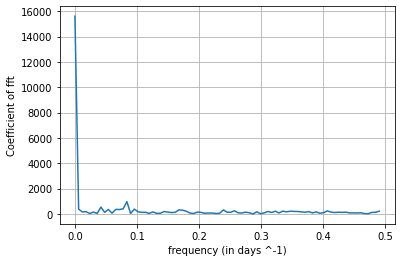

In [ ]:
plt.plot(xf, 2.0/N * np.abs(fft_y[0:N//2]))
plt.grid()
plt.xlabel ("frequency (in days ^-1)")
plt.ylabel ("Coefficient of fft")
plt.show()

In [ ]:
freqs = [x for _, x in sorted(zip(fft_y, xf),reverse=True)][0:10]

In [ ]:
from math import pi, cos, sin
for freq in freqs:
  vars = np.vstack((vars,np.array([cos(2*pi*freq*x) for x in t])))
  vars = np.vstack((vars,np.array([sin(2*pi*freq*x) for x in t])))

In [ ]:
test_df = pd.DataFrame(vars.T)

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(vars.T,Y)

LinearRegression()

In [ ]:
exog = sm.add_constant(vars.T)
mod = sm.OLS(Y,exog)
lr = mod.fit()
#lr = sm.OLS(Y,vars.T).fit()

lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     3.301
Date:                Tue, 03 May 2022   Prob (F-statistic):           1.61e-05
Time:                        16:47:21   Log-Likelihood:                -1412.2
No. Observations:                 167   AIC:                             2866.
Df Residuals:                     146   BIC:                             2932.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            16.0952      7.873      2.044      0.043       0.536      31.655
x2            -0.0677      0.045     -1.494      0.137      -0.157       0.022
const       7087.7959    287.810     24.627      0.000    6518.985    7656.607
x3          1.703e-13   2.06e-14      8.287      0.000     1.3e-13    2.11e-13
x4           425.4958    133.278      3.193      0.002     162.093     688.898
x5          -304.4910    134.082     -2.271      0.025    -569.483     -39.499
x6           347.5245    133.262      2.608      0.010      84.154     610.895
x7           -14.7401    133.745     -0.110      0.912    -279.067     249.587
x8           334.6438    133.257      2.511      0.013      71.283     598.005
x9           147.8216    133.574      1.107      0.270    -116.168     411.811
x10          332.3881    133.255      2.494      0.014      69.030     595.747
x11          117.1038    133.519      0.877      0.382    -146.776     380.984
x12          243.7010    133.253      1.829      0.069     -19.652     507.054
x13           54.9522    133.251      0.412      0.681    -208.398     318.303
x14          210.0738    133.253      1.577      0.117     -53.279     473.427
x15            4.1503    133.275      0.031      0.975    -259.247     267.547
x16          200.4235    133.253      1.504      0.135     -62.930     463.777
x17           72.5552    133.243      0.545      0.587    -190.780     335.890
x18          200.4156    133.255      1.504      0.135     -62.941     463.773
x19          368.3500    133.476      2.760      0.007     104.555     632.145
x20          181.1029    133.253      1.359      0.176     -82.250     444.456
x21          -57.0148    133.244     -0.428      0.669    -320.352     206.322
==============================================================================
Omnibus:                        5.735   Durbin-Watson:                   1.475
Prob(Omnibus):                  0.057   Jarque-Bera (JB):                5.595
Skew:                           0.448   Prob(JB):                       0.0610
Kurtosis:                       3.053   Cond. No.                     4.17e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.52e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

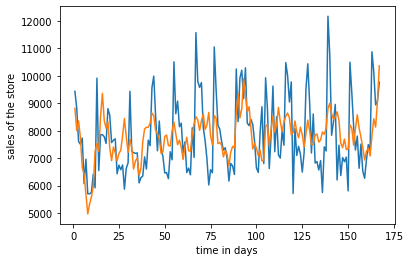

In [ ]:
plt.plot(t,Y)
plt.xlabel ("time in days")
plt.ylabel ("sales of the store")
plt.plot(t,lr.predict(vars.T))

In [ ]:
t_prediction = np.arange(t.max(),t.max()+42,1)
vars_predict = np.array(t_prediction)

vars_predict = np.vstack((vars_predict,np.array([x**2 for x in t_prediction])))

for freq in freqs:
  vars_predict = np.vstack((vars_predict,np.array([cos(2*pi*freq*x) for x in t_prediction])))
  vars_predict = np.vstack((vars_predict,np.array([sin(2*pi*freq*x) for x in t_prediction])))

In [ ]:
predictions = lr.predict(vars_predict.T)

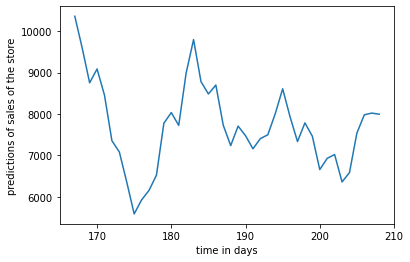

In [ ]:
plt.plot(t_prediction,predictions)
plt.xlabel ("time in days")
plt.ylabel ("predictions of sales of the store")
plt.show()

# Dynamic Linear Modeling

In [ ]:
!pip3 install pydlm

     |████████████████████████████████| 46 kB 1.8 MB/s 
  Created wheel for pydlm: filename=pydlm-0.1.1.11-py2.py3-none-any.whl size=58995 sha256=d73401997152bb5a69127026c54d12c27e76807c87a0fffa9cae469bd9e9f3d0
  Stored in directory: /root/.cache/pip/wheels/1d/fb/0c/6611fce0b9f3611ac6498dbddb7a9b5e67c09684acf6db285d
Successfully built pydlm


In [ ]:


from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
# randomly generate data
data = Y
# construct the base
myDLM = dlm(data)
# adding model components
# add a first-order trend (linear trending) with prior covariance 1.0
myDLM = myDLM + trend(1, name='lineTrend', w=1.0)
# add a 7 day seasonality with prior covariance 1.0
myDLM = myDLM + seasonality(7, name='7day', w=1.0)
# add a 3 step auto regression
myDLM = myDLM + autoReg(degree=3, data=data, name='ar3', w=1.0)
# show the added components
myDLM.ls()
# delete unwanted component
myDLM.delete('7day')
myDLM.ls()

The static components are
lineTrend (degree = 2)
7day (degree = 7)
 
There is no dynamic component.
 
The automatic components are
ar3 (dimension = 3)
The static components are
lineTrend (degree = 2)
 
There is no dynamic component.
 
The automatic components are
ar3 (dimension = 3)


/usr/local/lib/python3.7/dist-packages/pydlm/modeler/autoReg.py:74: UserWarning: The data argument in autoReg is deprecated. Please avoid using it.
  warn('The data argument in autoReg is deprecated. Please avoid using it.')


In [ ]:
# fit forward filter
myDLM.fitForwardFilter()
# fit backward smoother
myDLM.fitBackwardSmoother()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


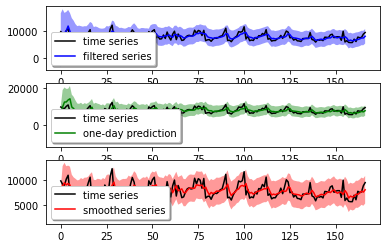

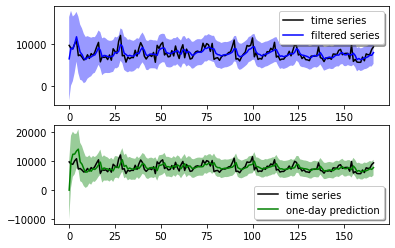

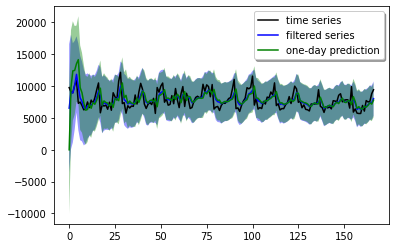

In [ ]:
# plot the results
myDLM.plot()
# plot only the filtered results
myDLM.turnOff('smoothed plot')
myDLM.plot()
# plot in one figure
myDLM.turnOff('multiple plots')
myDLM.plot()